Goal is to remove zernike polynomials from image

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack as fft
from astropy.io import fits
from scipy import optimize
from poppy import zernikeke


import file

In [2]:
#filename = "/Users/melisatallis/Documents/Research/GPIDomeSeeing/data/aotelem/aored_When_2016.2.27_0.40.14_poldm_phase.fits"
#filename = "/Users/melisatallis/Documents/Research/GPIDomeSeeing/data/aotelem/aored_When_2016.2.29_22.29.18_poldm_phase.fits"
filename = "/Users/MelisaT/Documents/Research/GPIDomeSeeing/data/Reduced/20160229/aored_When_2016.2.29_5.33.19_poldm_phase.fits"


hdulist = fits.open(filename,memmap=True)
phase = hdulist[0].data.astype('float')

# Get the phase dimensions
phdim = phase.shape 
phx   = phdim[1]
phy   = phdim[2]
timesteps = phdim[0]

print(phdim)

(21900, 48, 48)


aperture

In [39]:
outD = 7.77010  # primary diameter (m)
inD = 1.024  # inner M2 diameter (m)
m  = 8 

## GPI DM parameters
n = 48          # number sample points across the screen 
                # (Not the number of subapertures across the aperture which is less)
nacross = 43.2    # number of subapertures across the aperture
    
## phase sample parameters
pscale = outD/(nacross)   #  pixel size (m) of samples in pupil plane

In [40]:
x = np.linspace(-(n)/2,(n)/2,n)*pscale 
y = np.linspace(-(n)/2,(n)/2,n)*pscale
mg = np.meshgrid(x,y)
ar = np.sqrt(np.sum((m**2 for m in mg)))
ap_outer = (ar <= outD/2)
ap_inner = (ar <= inD/2)   
aperture = (ap_outer ^ ap_inner).astype(int)

In [117]:
aperture_nan = np.copy(aperture.astype(np.float))
aperture_nan[np.where(aperture==0)] = np.nan

plot image

In [3]:
def implot(image, display=True, **kwargs):
    """Plot an image with colorbar.
    
    image - The 2d image
    kwargs - settings for curstomizing plot"""

    ## Create matplotlib figure 
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    cax = ax.imshow(image, cmap = plt.cm.Greys, origin='lower', interpolation='none')
    cbar = fig.colorbar(cax, orientation='vertical')

    ## Modify plot based on keyword arguments
    if 'title' in kwargs: ax.set_title(kwargs['title'], fontsize=24)
    if 'xlabel' in kwargs: ax.set_xlabel(kwargs['xlabel'], fontsize=16)
    if 'ylabel' in kwargs: ax.set_ylabel(kwargs['ylabel'], fontsize=16)
    if 'cbar_label' in kwargs: cbar.set_label(kwargs['cbar_label'], 
                                              fontsize=18)
    if 'save_image' in kwargs: plt.savefig(kwargs['save_image'])

    if display: plt.show()

<IPython.core.display.Javascript object>


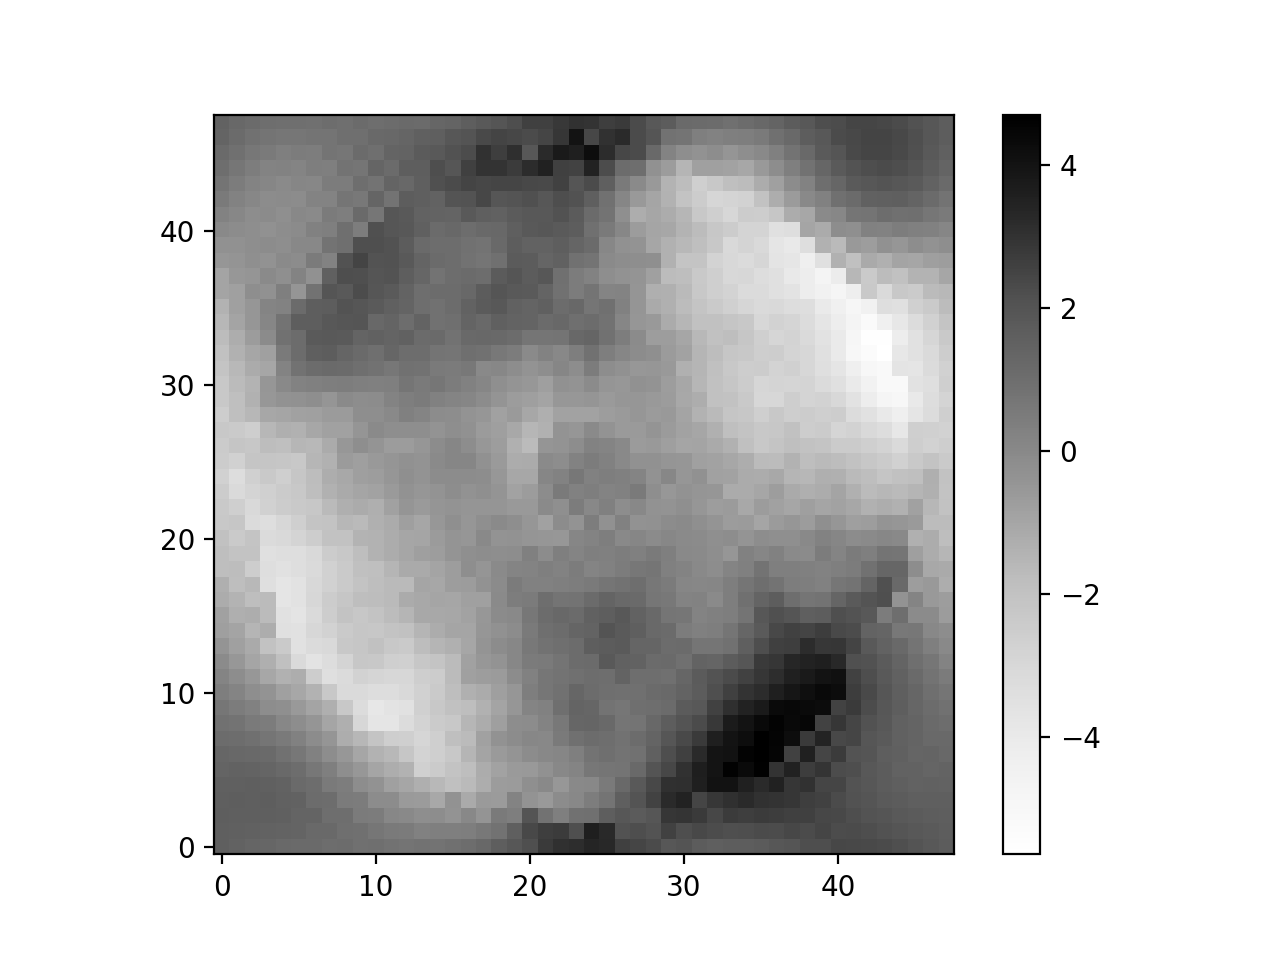

In [5]:
%matplotlib notebook
implot(phase[0])

In [49]:
zernike.zern_name(6)

'Astigmatism 0'

In [110]:
piston = zernike.zernike1(1,npix=43)
astigmatism = zernike.zernike1(5,npix=43)

<IPython.core.display.Javascript object>


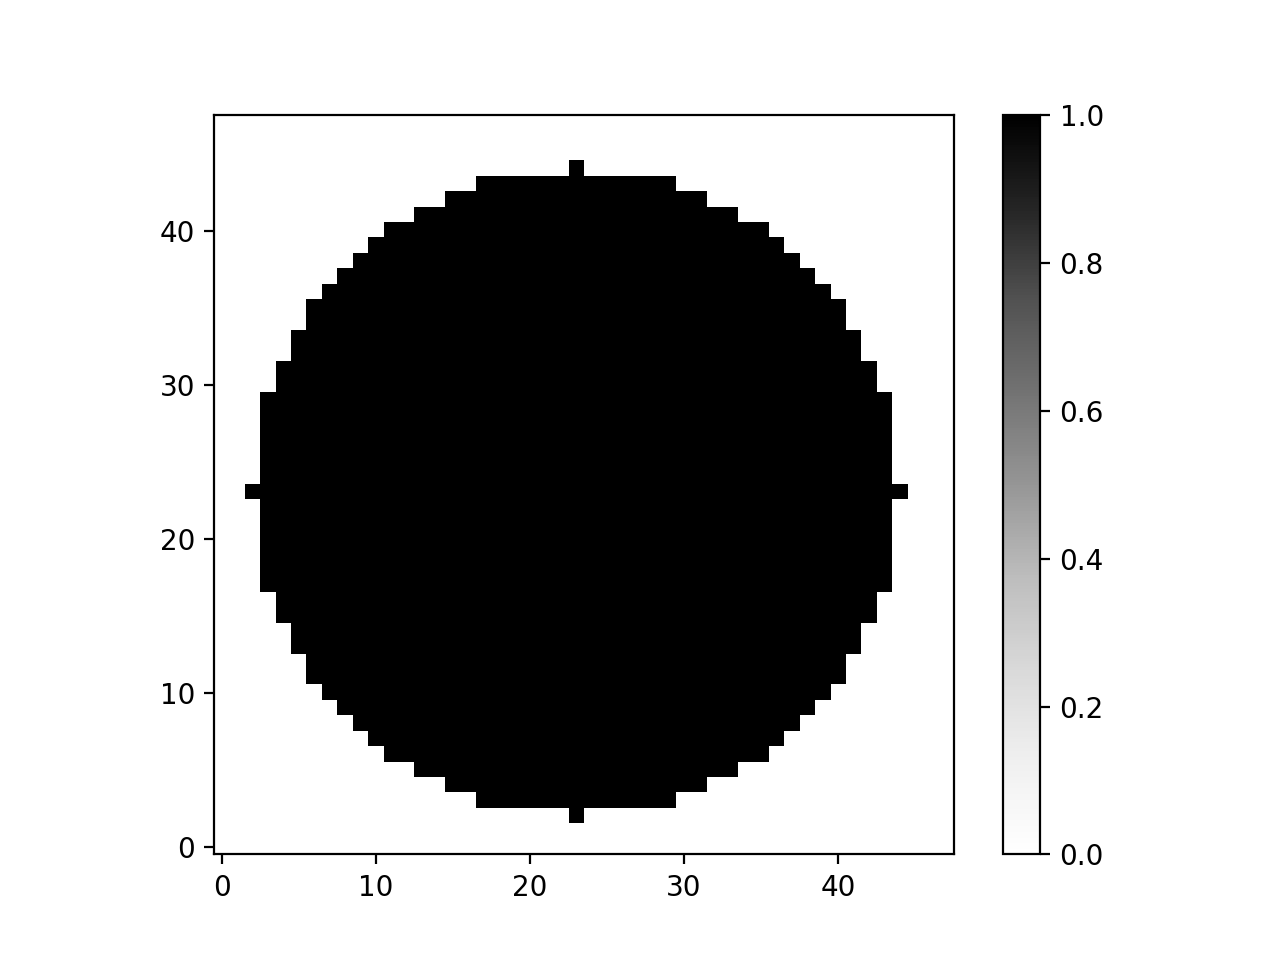

In [112]:
implot(np.pad(piston,[(2, 3), (2,3)], mode='constant', constant_values=0))

In [122]:
coefficients = zernike.opd_expand_nonorthonormal(phase[0],aperture= aperture,nterms=6)

ValueError: operands could not be broadcast together with shapes (48,48) (5,5) 

In [113]:
zernike_basis = zernike.zernike_basis(nterms= 6, npix = 48)

In [82]:
print(zernike_basis.shape)
print(coefficients.shape)

(6, 43, 43)
(6,)


In [108]:
t = np.pad(thin_lens,[(2, 3), (2,3)], mode='constant', constant_values=0)
t.shape

(48, 48)

In [114]:
thin_lens = np.sum(coefficients[:,None,None]*zernike_basis[:,:,:],axis=0)

In [120]:
np.nanmean(aperture_nan*(phase[0]-thin_lens))

-0.00053221774174587596

<IPython.core.display.Javascript object>


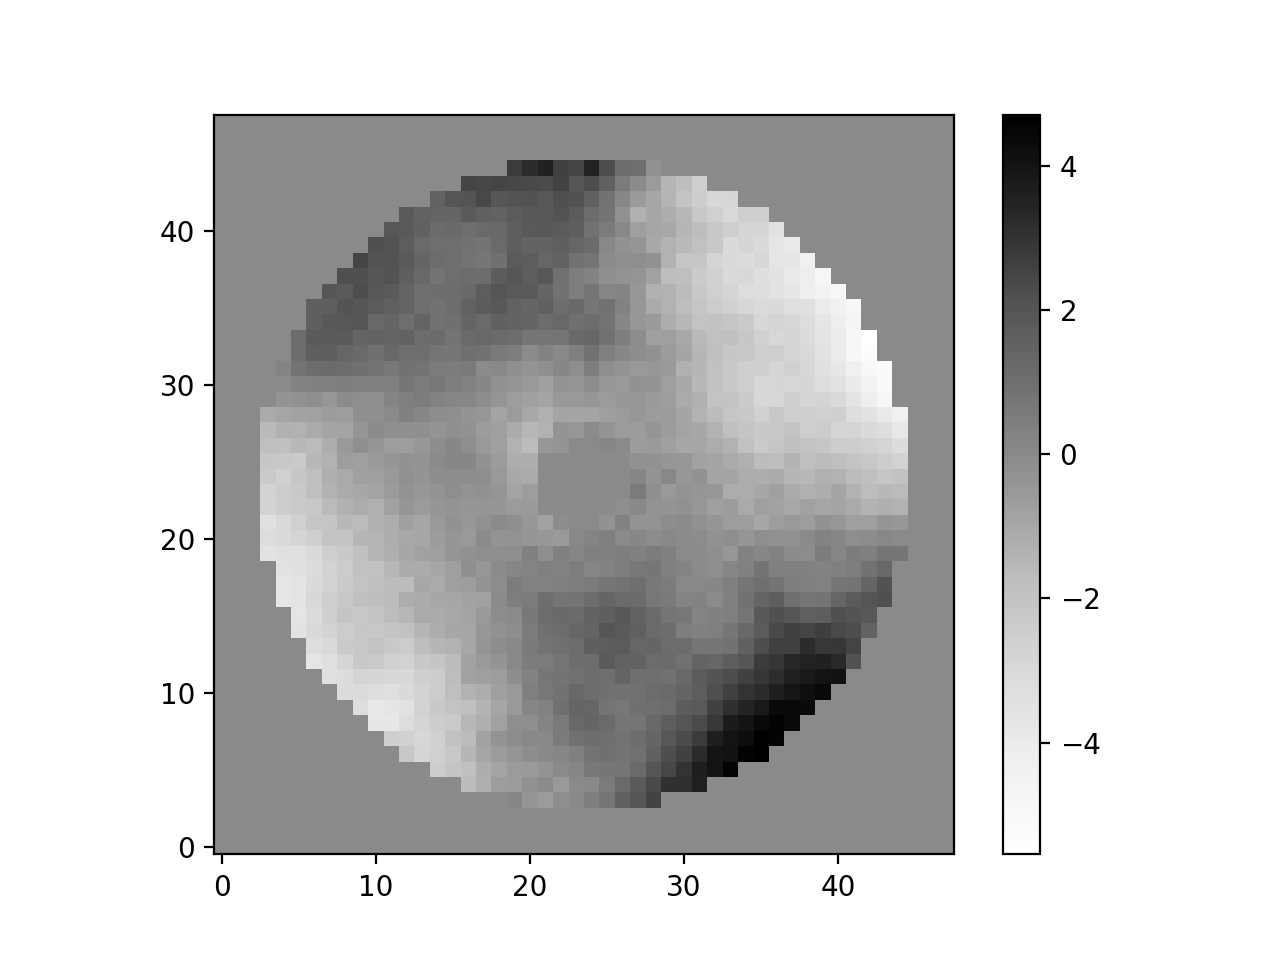

In [80]:
np.a(phase[0]*aperture)

In [45]:
(np.nansum(piston*phase[0])/(np.nansum(piston*piston)))

-0.25050338895639757

In [35]:
thin_lens1 = (np.nansum(piston*phase[0])/(np.nansum(piston*piston)))*piston
thin_lens2 = (np.nansum(astigmatism*phase[0])/(np.nansum(astigmatism*astigmatism)))*astigmatism

<IPython.core.display.Javascript object>


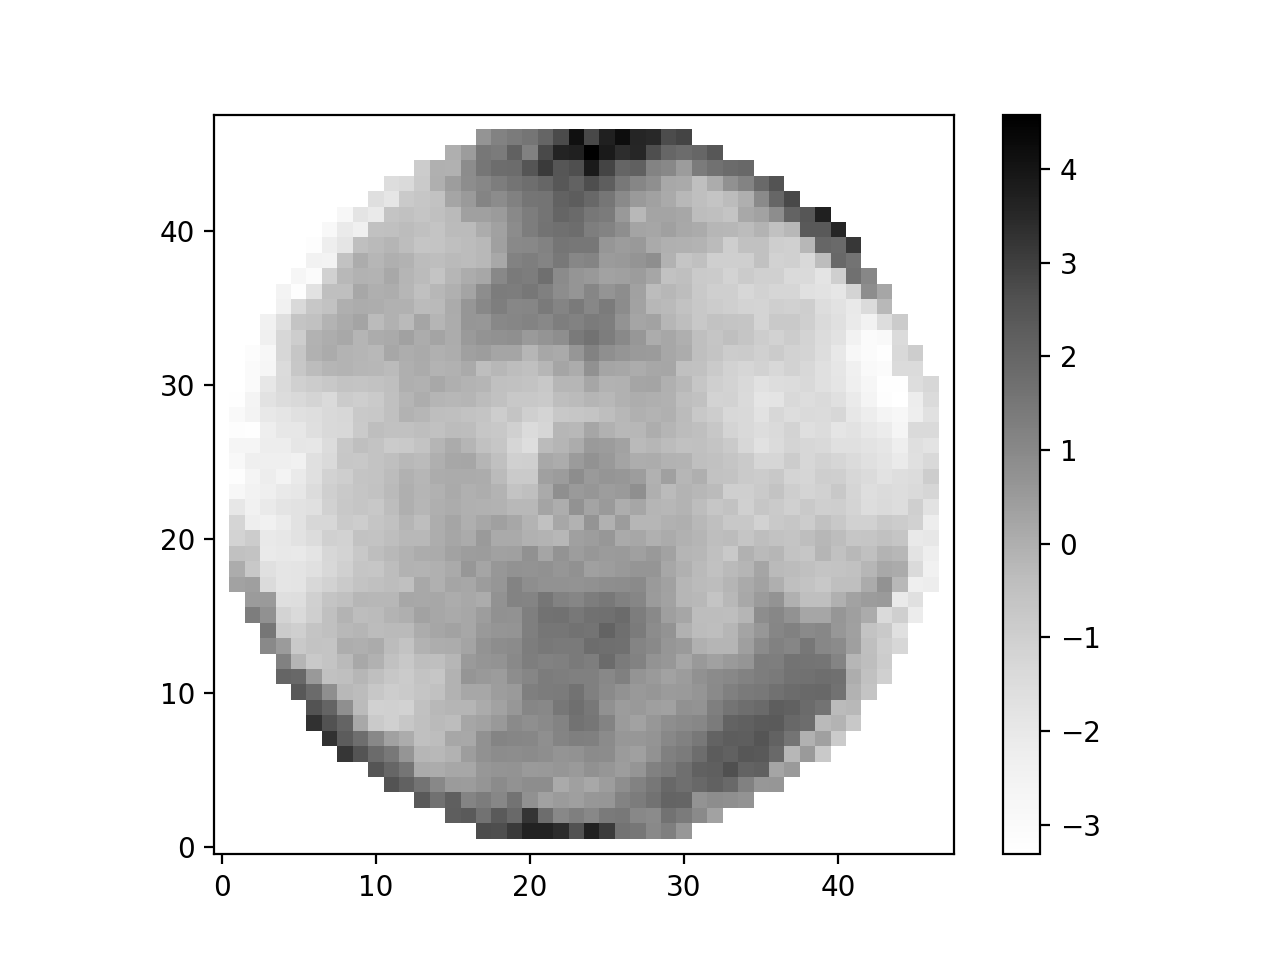

In [37]:
implot(phase[0]-thin_lens2-thin_lens1)